In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
from PIL import Image
import tensorflow as tf
import tensorflow.keras as K

from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pre
from glob import glob

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

size = 224
os.environ["CUDA_VISIBLE_DEVICES"] = "0"



def createDirectory(directory):
    """_summary_
        create Directory
    Args:
        directory (string): file_path
    """    
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")

In [ ]:
test_df = pd.read_csv(
    '../../data/classificationDDH/test_aug_classification_dataset.csv')


test_img_list = test_df['file name'].to_list()
test_label_list = test_df['standard class'].to_list()
test_case_list = test_df['case'].to_list()
test_img_path = '../../data/classificationDDH/aug_dataset/test/'


x_test = np.zeros((len(test_img_list), size, size, 3), dtype=np.uint8)
for i in tqdm(range(len(test_img_list))):
    x_test[i] = np.array(Image.open(
        test_img_path+str(test_case_list[i])+'/'+test_img_list[i]).resize((size, size)))
y_test = np.array(test_label_list)


In [ ]:
model = K.models.load_model('../../model/classification/MobileNetV2_checkpoints.h5')
MobileNetV2_pre=model.predict(x_test)
print(model.count_params())
model = K.models.load_model('../../model/classification/MobileNetV1_acc_checkpoints.h5')
MobileNetV1_pre=model.predict(x_test)
print(model.count_params())
model = K.models.load_model('../../model/classification/DenseNet121_checkpoints.h5')
DenseNet121_pre=model.predict(x_test)
print(model.count_params())
model = K.models.load_model('../../model/classification/EfficientNetV2B0_checkpoints.h5')
EfficientNetV2B0_pre=model.predict(x_test)
print(model.count_params())
model = K.models.load_model('../../model/classification/NASNetMobile_checkpoints.h5')
NASNetMobile_pre=model.predict(x_test)
print(model.count_params())
model = K.models.load_model('../../model/classification/ResNet50_checkpoints.h5')
ResNet50_pre=model.predict(x_test)
print(model.count_params())

(0.0, 1.0)

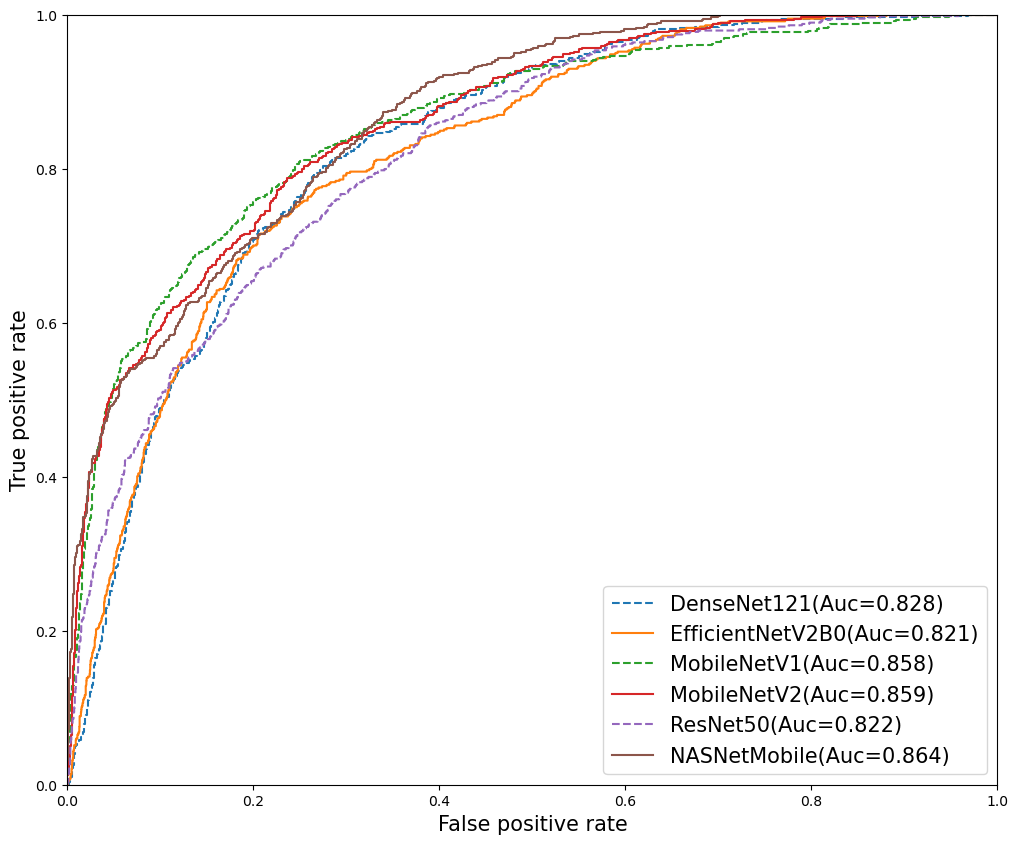

In [27]:
MobileNetV2_fper,MobileNetV2_tper, thresholds = roc_curve(y_test, MobileNetV2_pre)
MobileNetV1_fper,MobileNetV1_tper, thresholds = roc_curve(y_test, MobileNetV1_pre)
DenseNet121_fper,DenseNet121_tper, thresholds = roc_curve(y_test, DenseNet121_pre)
EfficientNetV2B0_fper,EfficientNetV2B0_tper, thresholds = roc_curve(y_test, EfficientNetV2B0_pre)
NASNetMobile_fper,NASNetMobile_tper, thresholds = roc_curve(y_test, NASNetMobile_pre)
ResNet50_fper,ResNet50_tper, thresholds = roc_curve(y_test, ResNet50_pre)
MobileNetV2_auc_score=roc_auc_score(y_test, MobileNetV2_pre)
MobileNetV1_auc_score=roc_auc_score(y_test, MobileNetV1_pre)
DenseNet121_auc_score=roc_auc_score(y_test, DenseNet121_pre)
EfficientNetV2B0_auc_score=roc_auc_score(y_test, EfficientNetV2B0_pre)
NASNetMobile_auc_score=roc_auc_score(y_test, NASNetMobile_pre)
ResNet50_auc_score=roc_auc_score(y_test, ResNet50_pre)
plt.figure(figsize=(12,10))
plt.plot(DenseNet121_fper, DenseNet121_tper,label='DenseNet121(Auc='+str(round(DenseNet121_auc_score, 3))+')',linestyle='--')
plt.plot(EfficientNetV2B0_fper, EfficientNetV2B0_tper,label='EfficientNetV2B0(Auc='+str(round(EfficientNetV2B0_auc_score, 3))+')')
plt.plot(MobileNetV1_fper, MobileNetV1_tper,label='MobileNetV1(Auc='+str(round(MobileNetV1_auc_score, 3))+')',linestyle='--')
plt.plot(MobileNetV2_fper,MobileNetV2_tper,label='MobileNetV2(Auc='+str(round(MobileNetV2_auc_score, 3))+')')
plt.plot(ResNet50_fper,ResNet50_tper,label='ResNet50(Auc='+str(round(ResNet50_auc_score, 3))+')',linestyle='--')
plt.plot(NASNetMobile_fper,NASNetMobile_tper,label='NASNetMobile(Auc='+str(round(NASNetMobile_auc_score, 3))+')')
plt.legend(fontsize=15)
plt.xlabel('False positive rate',size=15)
plt.ylabel('True positive rate',size=15)
plt.xlim([0, 1])      # X축의 범위: [xmin, xmax]
plt.ylim([0, 1]) 


In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample
def weight_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision=tp / (tp+fp)
 
    f1 = (2*sensitivity*precision)/(sensitivity+precision)
    weight=f1+sensitivity/4
    return weight
# Define a function to find the optimal threshold
def find_optimal_threshold(y_true, y_scores):
    thresholds = np.arange(0.01, 1.0, 0.01)
    f1_scores = [weight_metrics(y_true, (y_scores > t).astype(int)) for t in thresholds]
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    return optimal_threshold

# Find optimal threshold for each model
MobileNetV2_optimal_threshold = find_optimal_threshold(y_test, MobileNetV2_pre)
MobileNetV1_optimal_threshold = find_optimal_threshold(y_test, MobileNetV1_pre)
DenseNet121_optimal_threshold = find_optimal_threshold(y_test, DenseNet121_pre)
EfficientNetV2B0_optimal_threshold = find_optimal_threshold(y_test, EfficientNetV2B0_pre)
NASNetMobile_optimal_threshold = find_optimal_threshold(y_test, NASNetMobile_pre)
ResNet50_optimal_threshold = find_optimal_threshold(y_test, ResNet50_pre)
# Define a function to calculate metrics
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision=tp / (tp+fp)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = (2*sensitivity*precision)/(sensitivity+precision)
    return sensitivity, specificity, accuracy, f1

def bootstrap_ci(metric, y_true, y_pred, n_iterations=1000, ci=95):
    values = []
    for _ in range(n_iterations):
        indices = resample(range(len(y_true)), replace=True)
        resampled_true = y_true[indices]
        resampled_pred = y_pred[indices]
        values.append(metric(resampled_true, resampled_pred))
    
    alpha = (100 - ci) / 2.0
    lower = max(0.0, np.percentile(values, alpha))
    upper = min(1.0, np.percentile(values, 100 - alpha))
    
    return lower, upper

def performance_ci(model_name,test,predict,threshold):
    ci_auc_lower, ci_auc_upper = bootstrap_ci(roc_auc_score, test, predict)
    ci_sensitivity_lower, ci_sensitivity_upper = bootstrap_ci(recall_score, test, (predict >threshold).astype(int))
    ci_specificity_lower, ci_specificity_upper = bootstrap_ci(
    lambda x, y: confusion_matrix(x, y).ravel()[0] / (confusion_matrix(x, y).ravel()[0] + confusion_matrix(x, y).ravel()[1]),
    test,
    (predict > threshold).astype(int)
)
    ci_accuracy_lower, ci_accuracy_upper = bootstrap_ci(accuracy_score, test, (predict >threshold).astype(int))
    ci_f1_lower, ci_f1_upper = bootstrap_ci(f1_score, test, (predict >threshold).astype(int))
    print("{}: AUC={}({}-{}), Sensitivity={}({}-{}), Specificity={}({}-{}), Accuracy={}({}-{}), F1-Score={}({}-{})".format(model_name,round((ci_auc_upper+ci_auc_lower)/2,3),round(ci_auc_lower,3),round(ci_auc_upper,3),round((ci_sensitivity_upper+ci_sensitivity_lower)/2,3),round(ci_sensitivity_lower,3), round(ci_sensitivity_upper,3),round((ci_specificity_upper+ci_specificity_lower)/2,3),round(ci_specificity_lower,3),round(ci_specificity_upper,3), round((ci_accuracy_upper+ci_accuracy_lower)/2,3),round(ci_accuracy_lower,3),round(ci_accuracy_upper,3), round((ci_f1_upper+ci_f1_lower)/2,3),round(ci_f1_lower,3),round(ci_f1_upper,3)))
    
# Calculate metrics for each model
MobileNetV2_sensitivity, MobileNetV2_specificity, MobileNetV2_accuracy, MobileNetV2_f1 = calculate_metrics(y_test, (MobileNetV2_pre > MobileNetV2_optimal_threshold ).astype(int))
MobileNetV1_sensitivity, MobileNetV1_specificity, MobileNetV1_accuracy, MobileNetV1_f1 = calculate_metrics(y_test, (MobileNetV1_pre > MobileNetV1_optimal_threshold).astype(int))
DenseNet121_sensitivity, DenseNet121_specificity, DenseNet121_accuracy, DenseNet121_f1 = calculate_metrics(y_test, (DenseNet121_pre > DenseNet121_optimal_threshold).astype(int))
EfficientNetV2B0_sensitivity, EfficientNetV2B0_specificity, EfficientNetV2B0_accuracy, EfficientNetV2B0_f1 = calculate_metrics(y_test, (EfficientNetV2B0_pre > EfficientNetV2B0_optimal_threshold).astype(int))
NASNetMobile_sensitivity, NASNetMobile_specificity, NASNetMobile_accuracy, NASNetMobile_f1 = calculate_metrics(y_test, (NASNetMobile_pre > NASNetMobile_optimal_threshold).astype(int))
ResNet50_sensitivity, ResNet50_specificity, ResNet50_accuracy, ResNet50_f1 = calculate_metrics(y_test, (ResNet50_pre > ResNet50_optimal_threshold).astype(int))


print("model performance(95% CI)")
performance_ci('MobileNetV2',y_test,MobileNetV2_pre,MobileNetV2_optimal_threshold)
performance_ci('MobileNetV1',y_test,MobileNetV1_pre,MobileNetV1_optimal_threshold)
performance_ci('DenseNet121',y_test,DenseNet121_pre,DenseNet121_optimal_threshold)
performance_ci('EfficientNetV2B0',y_test,EfficientNetV2B0_pre,EfficientNetV2B0_optimal_threshold)
performance_ci('NASNetMobile',y_test,NASNetMobile_pre,NASNetMobile_optimal_threshold)
performance_ci('ResNet50',y_test,ResNet50_pre,ResNet50_optimal_threshold)


/tmp/ipykernel_159776/2233987965.py:7: RuntimeWarning: invalid value encountered in long_scalars
  precision=tp / (tp+fp)
/tmp/ipykernel_159776/2233987965.py:7: RuntimeWarning: invalid value encountered in long_scalars
  precision=tp / (tp+fp)
/tmp/ipykernel_159776/2233987965.py:7: RuntimeWarning: invalid value encountered in long_scalars
  precision=tp / (tp+fp)
/tmp/ipykernel_159776/2233987965.py:7: RuntimeWarning: invalid value encountered in long_scalars
  precision=tp / (tp+fp)
/tmp/ipykernel_159776/2233987965.py:7: RuntimeWarning: invalid value encountered in long_scalars
  precision=tp / (tp+fp)
/tmp/ipykernel_159776/2233987965.py:7: RuntimeWarning: invalid value encountered in long_scalars
  precision=tp / (tp+fp)
/tmp/ipykernel_159776/2233987965.py:7: RuntimeWarning: invalid value encountered in long_scalars
  precision=tp / (tp+fp)
/tmp/ipykernel_159776/2233987965.py:7: RuntimeWarning: invalid value encountered in long_scalars
  precision=tp / (tp+fp)
/tmp/ipykernel_159776/22

model performance(95% CI)


KeyboardInterrupt: 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import resnet50, ResNet50
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
model = K.models.load_model('../../model/classification/MobileNetV2_checkpoints.h5')
resnet = model.get_layer('mobilenetv2_1.00_224')
last_conv_layer=resnet.get_layer('Conv_1')
model_1= keras.Model(resnet.inputs, last_conv_layer.output)
input_2 = keras.Input(shape=last_conv_layer.output.shape[1:])
x_2 = resnet.get_layer("global_average_pooling2d")(input_2)
x_2 = resnet.get_layer("predictions")(x_2)
model_2=keras.Model(input_2,x_2)

for image_index in np.where(y_test==1)[0]:
    with tf.GradientTape() as tape:
        output_1 = model_1(x_test[image_index:image_index+1])
        tape.watch(output_1) #마지막 층으로 미분하기 위한 준비
        preds = model_2(output_1)
        class_id = tf.argmax(preds[0])
        output_2 = preds[:,class_id]

    grads = tape.gradient(output_2, output_1) #그레디언트 계산
    pooled_grads = tf.reduce_mean(grads,axis=(0,1,2)) #식5 적용

    output_1 = output_1.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        output_1[:,:,i]*=pooled_grads[i]
    heatmap=np.mean(output_1, axis=-1)

    heatmap =np.maximum(heatmap, 0)/np.max(heatmap) #정규화

    #열지도를 입력 영상에 씌움
    img =x_test[image_index]
    heatmap=np.uint8(255*heatmap) # [0,255]로 변환

    jet = cm.get_cmap("jet") #jet 컬러맵으로 표시
    color = jet(np.arange(256))[:,:3]
    color_heatmap = color[heatmap]

    color_heatmap = keras.preprocessing.image.array_to_img(color_heatmap)
    color_heatmap = color_heatmap.resize((img.shape[1], img.shape[0]))
    color_heatmap = keras.preprocessing.image.img_to_array(color_heatmap)

    overlay_img= color_heatmap+img #덧씌움
    overlay_img = (overlay_img/overlay_img.max()*255).astype(np.uint8)  # 이미지의 픽셀 깊이를 8비트로 변환
    overlay_img = cv2.cvtColor(overlay_img, cv2.COLOR_RGB2BGR) 
    img = (img/img.max()*255).astype(np.uint8)
    img=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    cv2.imwrite('../../data/heatmap/MobileNetV2/'+str(image_index)+'.jpg',overlay_img)
plt.imshow(img)
plt.show()
plt.imshow(overlay_img)

In [ ]:
resnet.summary()